In [5]:
import pandas as pd
import numpy as np
import re
import string

data = pd.read_csv("/kaggle/input/nlp-t3/train.csv", encoding="latin1")

In [6]:
data['Tag'].value_counts()


O                 226739
I_PRECEDENT         9648
I_PROVISION         3330
I_CASE_NUMBER       3106
I_STATUTE           2740
B_OTHER_PERSON      2279
I_ORG               2273
I_COURT             2164
B_PROVISION         2042
I_OTHER_PERSON      1772
B_DATE              1590
B_STATUTE           1523
B_ORG               1229
B_GPE               1186
I_DATE              1163
B_PRECEDENT         1123
B_COURT             1103
B_CASE_NUMBER        884
B_WITNESS            760
I_WITNESS            634
B_JUDGE              489
B_PETITIONER         401
I_RESPONDENT         365
I_JUDGE              342
I_PETITIONER         323
B_RESPONDENT         274
I_GPE                240
Name: Tag, dtype: int64

In [7]:
data.head(1)

,Sentence #,Word,Tag
0,1,"Therefore,",O


In [8]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
          
getter = SentenceGetter(data)
sentences = getter.sentences

In [9]:
print(sentences[1:3])

[[('The', 'O'), ('petitioner', 'O'), ('in', 'O'), ('W.P.No.15821', 'B_CASE_NUMBER'), ('of', 'I_CASE_NUMBER'), ('2008', 'I_CASE_NUMBER'), ('was', 'O'), ('never', 'O'), ('considered', 'O'), ('for', 'O'), ('appointment', 'O'), ('under', 'O'), ('the', 'O'), ('National', 'B_ORG'), ('Rural', 'I_ORG'), ('Employment', 'I_ORG'), ('Guarantee', 'I_ORG'), ('Scheme', 'I_ORG'), ('either', 'O'), ('through', 'O'), ('Employment', 'O'), ('Exchange', 'O'), ('sponsorship', 'O'), ('or', 'O'), ('by', 'O'), ('Outsourcing', 'O'), ('Agencies.', 'O')], [('The', 'O'), ('factum', 'O'), ('of', 'O'), ('accident,', 'O'), ('allegation', 'O'), ('of', 'O'), ('rash', 'O'), ('and', 'O'), ('negligent', 'O'), ('driving', 'O'), ('causing', 'O'), ('death', 'O'), ('of', 'O'), ('Sukendra', 'B_OTHER_PERSON'), ('Pal', 'I_OTHER_PERSON'), ('Singh', 'I_OTHER_PERSON'), ('were', 'O'), ('denied.', 'O')]]


In [10]:
from math import nan

words = list(set(data["Word"].values))
n_words = len(words)

tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

## Prepare the data
Now we introduce dictionaries of words and tags.

In [11]:
from future.utils import iteritems

word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [12]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

maxlen = max([len(s) for s in sentences])

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=n_tags) for i in y]

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Using TensorFlow backend.


## Setup the CRF-BILSTM



In [13]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-et3o2fc9
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-et3o2fc9
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=493921b2f61409ced3ee9a854df56dfd1e042bb45b5c35b518fc419c772ac880
  Stored in directory: /tmp/pip-ephem-wheel-cache-g6zic1j_/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [14]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF

In [15]:
print(k.__version__)

2.3.1


In [16]:
input = Input(shape=(76,))
word_embedding_size = 150

embedding_path = '/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'
embedding_dim = 100
def load_glove_embeddings(embedding_path, embedding_dim, word_index):
    embeddings_index = {}
    with open(embedding_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = load_glove_embeddings(embedding_path, embedding_dim, word2idx)



# Embedding Layer
model = Embedding(input_dim=n_words+1, 
                  output_dim=embedding_dim, 
                  weights=[embedding_matrix], 
                  input_length=76, 
                  trainable=False)(input)
# BI-LSTM Layer
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)

# TimeDistributed Layer
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  

# CRF Layer
crf = CRF(n_tags)

out = crf(model)  # output
model = Model(input, out)

In [17]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 76)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 76, 100)           3166100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 76, 300)           301200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 76, 300)           721200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 76, 27)            8127      
_________________________________________________________________
crf_1 (CRF)                  (None, 76, 27)            1539      
Total params: 4,198,166
Trainable params: 1,032,066
Non-trainable params: 3,166,100
_________________________________________

In [18]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val
#Optimiser 
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

# Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])

model.summary()

# Saving the best model only
filepath="ner-bi-lstm-td-model-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the best model
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=10, validation_split=0.1, verbose=1, callbacks=callbacks_list)

/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 76)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 76, 100)           3166100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 76, 300)           301200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 76, 300)           721200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 76, 27)            8127      
_________________________________________________________________
crf_1 (CRF)                  (None, 76, 27)            1539      
Total params: 4,198,166
Trainable params: 1,032,066
Non-trainable params: 3,166,100
_________________________________________

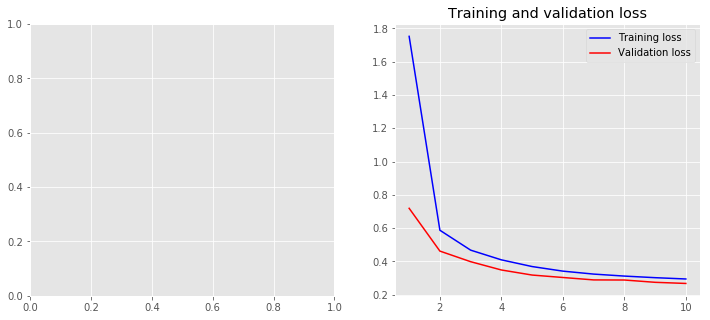

In [63]:
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [20]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

1604/1604 [==============================] - 3s 2ms/step


In [21]:
# ! pip install seqeval


     |████████████████████████████████| 51kB 5.0MB/s  eta 0:00:01
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16172 sha256=24b5f73bdc55366ba425d159c96f209af7c7511329d73d994ad79daa5338ff99
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [62]:
def F1_Score(y_test,y_pred):
    tp = {}
    fp = {}
    fn = {}

    classes = []
    for i in y_test:
        if i not in classes:
            classes.append(i)   
    for i in y_pred:
        if i not in classes:
            classes.append(i)
    for i in classes:
#         print(i)
        tp[i] = 0
        fp[i] = 0
        fn[i] = 0
    for i in range(len(y_test)):
        if y_test[i] == y_pred[i]:
            tp[y_test[i]] += 1
        else:
            fp[y_pred[i]] += 1
            fn[y_test[i]] += 1
    precision = {}
    recall = {}
    f = {}
    for i in classes:
#         print(i)
        if tp[i] == 0:
            precision[i] = 0
            recall[i] = 0
            f[i] = 0
        else:
            precision[i] = tp[i]/(tp[i]+fp[i])
            recall[i] = tp[i]/(tp[i]+fn[i])
            f[i] = 2*precision[i]*recall[i]/(precision[i]+recall[i])
    return f,precision,recall

# Example usage:
# # y_true and y_pred are lists containing true labels and predicted labels, respectively
# y_true = [0, 1, 2, 1, 2]
# y_pred = [0, 1, 1, 1, 2]

y_true = []
y_pred = []
for i in test_labels:
    for j in i:
        y_true.append(j)
for i in pred_labels:
    for j in i:
        y_pred.append(j)
# print(y_true)
precision, recall, f1_score = F1_Score(y_true, y_pred)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1_score)
for i in f1_score:
    print("F1 score for class ",i," is ",f1_score[i]," with precision ",precision[i]," and recall ",recall[i])
    
def avg_f1(f1):
    return sum(f1_score.values())/len(f1_score)
print("Average F1 score is ",avg_f1(f1_score))


F1 score for class  O  is  0.9906965669891269  with precision  0.9718381134866501  and recall  0.9536842105263158
F1 score for class  B_OTHER_PERSON  is  0  with precision  0  and recall  0
F1 score for class  I_OTHER_PERSON  is  0  with precision  0  and recall  0
F1 score for class  B_GPE  is  0  with precision  0  and recall  0
F1 score for class  B_DATE  is  0  with precision  0  and recall  0
F1 score for class  B_PRECEDENT  is  0  with precision  0  and recall  0
F1 score for class  I_PRECEDENT  is  0.8564022809745983  with precision  0.5476545665506382  and recall  0.40253411306042886
F1 score for class  B_COURT  is  0  with precision  0  and recall  0
F1 score for class  I_COURT  is  0  with precision  0  and recall  0
F1 score for class  I_DATE  is  0  with precision  0  and recall  0
F1 score for class  B_PROVISION  is  0  with precision  0  and recall  0
F1 score for class  I_PROVISION  is  0  with precision  0  and recall  0
F1 score for class  B_ORG  is  0  with precision 

In [30]:
from sklearn.metrics import f1_score


# Calculate F1 score
f1 = f1_score(test_labels, pred_labels, average='weighted')

# Print F1 score
print("F1-score: {:.1%}".format(f1))


from sklearn.metrics import f1_score

# Assuming test_labels and pred_labels are lists of labels for each sample in your test set
# For multiclass classification, set the 'average' parameter to 'weighted' to compute the weighted F1 score
f1 = f1_score(test_labels, pred_labels)

# Print the F1 score
print("Weighted F1-score: {:.2f}".format(f1))

ValueError: multiclass-multioutput is not supported

In [ ]:
# ! pip install sklearn_crfsuite
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)